In [97]:
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import random

from matplotlib import pyplot as plt
from pathlib import Path
#from scipy import stats

from p_body_randomness.extract_sample_areas import extract_sample_area
#from p_body_randomness.smooth_image import smooth_protein_image
from p_body_randomness.centroids import extract_centroids
from p_body_randomness.sampling import sample_pbodies
from p_body_randomness.metrics import nearest_neighbor_distance

In [85]:
# Plots containing cell images.

TEMPLATE_PATH = '../data/input_data/20180606-SLP_Multiplexing_p1_C03_x00{x}_y000_z000_t000_{image_type}_Label{label}.png'
NUM_IMAGES = 2
MIN_CENTROIDS = 5

image_types = {'pbodies': '13_Pbody_Segm', 'protein': '13_Succs', 'cellmask': 'segmentation', 'dapi': '2_DAPI'}

random.seed(42)

images = []
while len(images) < NUM_IMAGES:
    candidate = {'x': random.randint(0, 5), 'label': random.randint(0, 40)}
    if Path(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies'])).is_file():
        if len(extract_centroids(cv2.imread(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies']), 0))) >= MIN_CENTROIDS:
            images.append(candidate)

29.571534214066908
[24.23586422118975, 25.34450921823951, 28.804365017456444]
26.530296747718534
[25.840234244431354, 52.64780211323626, 35.53278856838625]


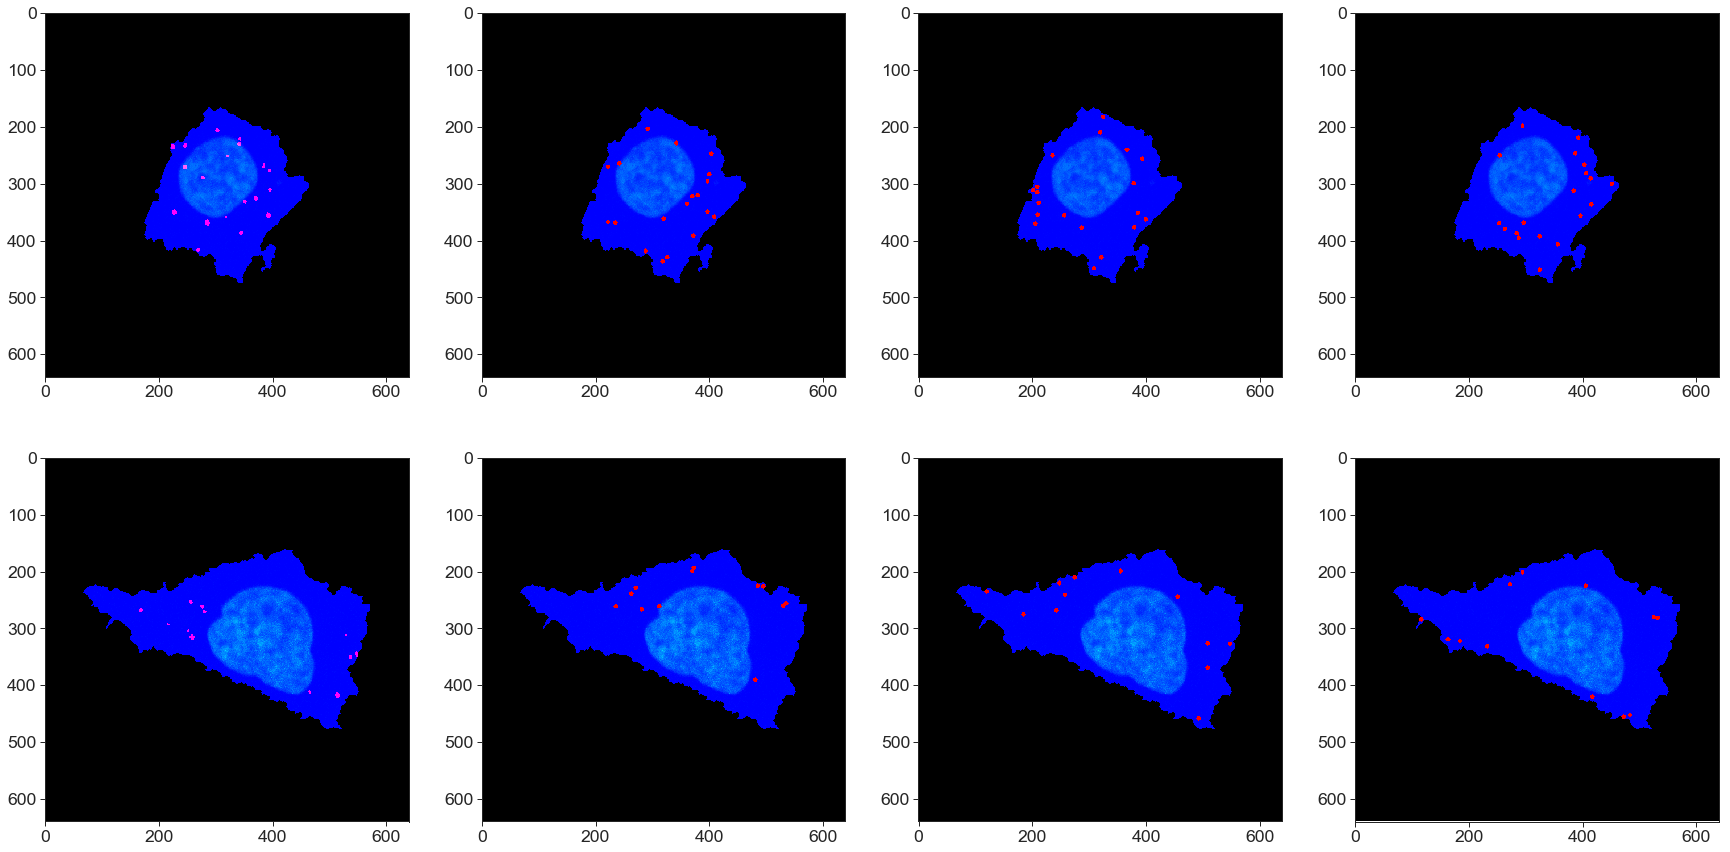

In [103]:
fig, axes = plt.subplots(ncols=4, nrows=NUM_IMAGES, figsize=(30, 15))

real_distances = []
simulated_distances = []

for i in range(NUM_IMAGES):
    # read raw channels
    pbodies_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['pbodies']), 0)
    dapi_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['dapi']), 0)
    cellmask_image = cv2.imread(TEMPLATE_PATH.format(**images[i], image_type=image_types['cellmask']), 0)
    
    # plot the available channels
    full_image = np.zeros((*pbodies_image.shape, 3), dtype=np.uint8)
    full_image[:, :, 0] = pbodies_image
    full_image[:, :, 1] = dapi_image
    full_image[:, :, 2] = cellmask_image
    axes[i, 0].imshow(full_image)
    
    centroids = extract_centroids(pbodies_image)

    # plot the sampled pbodies
    cytoplasmic_mask = extract_sample_area(cellmask_image, dapi_image)
    
    # Generating three simulation results.
    simulated_distances = []
    for j in range(3):
        sampled_pbodies = sample_pbodies(cytoplasmic_mask, len(centroids), area_fn=lambda: 100)
        sampled_image = np.zeros((*pbodies_image.shape, 3), dtype=np.uint8)
        sampled_image[:, :, 1] = dapi_image
        sampled_image[:, :, 2] = cellmask_image
    
        for sampled_pbody in sampled_pbodies:
            cv2.circle(sampled_image, (sampled_pbody[0], sampled_pbody[1]), int(np.sqrt(sampled_pbody[2]/np.pi)/1.25), (255, 0, 0), -1)

        axes[i, j+1].imshow(sampled_image)
        simulated_distances.append(np.mean(nearest_neighbor_distance(sampled_pbodies)))
    
    print(np.mean(nearest_neighbor_distance(centroids)))
    print(simulated_distances)

In [2]:
# Analysing the results from area sampling.
base_path = '../results/run2_randomSampling_uniform_ExcludeNuclearPbodies/NearestNeighborResults_'

# Load in all csv result files & combine them to one pandas table
wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',
         'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16',
         'E04', 'E05', 'E06', 'E07', 'E08', 'F04', 'F05', 'F06', 'F07', 'F08']

results = pd.DataFrame()

for well in wells:
    curr_well = pd.read_csv(base_path + well + '.csv')
    results = pd.concat([results, curr_well])

print(results.head())

   Area_of_Cytoplasm  Label  Mean_Of_mean_nn_distances_simulated_10  \
0            52160.0     27                               33.003230   
1            55056.0     28                               51.990571   
2            94739.0     14                               37.875042   
3            79842.0     35                               57.048077   
4            51296.0      9                               50.850828   

   Mean_Of_mean_nn_distances_simulated_100  \
0                                36.120900   
1                                45.037257   
2                                39.986709   
3                                60.879308   
4                                45.511252   

   Mean_Of_mean_nn_distances_simulated_1000  Mean_nn_distances_measured  \
0                                 35.660855                   38.279400   
1                                 44.468387                   47.995921   
2                                 39.753427                   41.035613

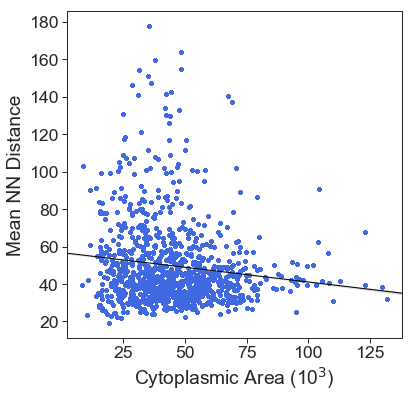

In [59]:
# Plot nearest neighbor distances against area of the cytoplasm.
sns.set(context = "paper", font_scale = 2, rc = {'figure.figsize':(6, 6)})
sns.set_style("ticks")
ax = sns.regplot(x = results["Area_of_Cytoplasm"]/1000, y = results["Mean_nn_distances_measured"],\
            scatter_kws={"color" : "royalblue","s": 10}, line_kws={'color': 'black', "lw" : 1})
ax.set_xlabel('Cytoplasmic Area (10$^3$)')
ax.set_ylabel('Mean NN Distance')
plt.show()

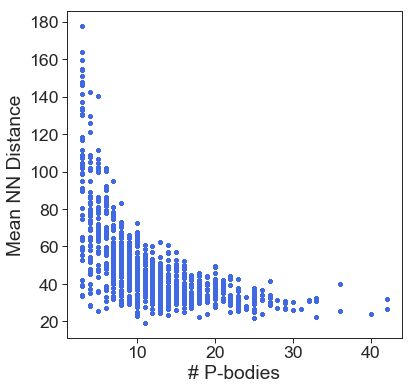

In [57]:
# Plot nearest neighbor distances against number of P-bodies.
sns.set(context = "paper", font_scale = 2, rc = {'figure.figsize':(6, 6)})
sns.set_style("ticks")
ax = sns.regplot(data = results, x = "Number_of_pbodies", y = "Mean_nn_distances_measured", \
             fit_reg = False, scatter_kws={"color" : "royalblue","s": 10})
ax.set_xlabel('# P-bodies')
ax.set_ylabel('Mean NN Distance')
plt.show()

Text(0.5,0,'# P-bodies')

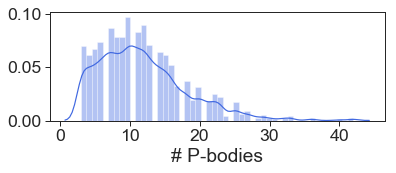

In [69]:
# Distribution of the number of P-Bodies.
sns.set(context = "paper", font_scale = 2, rc = {'figure.figsize':(6, 2)})
sns.set_style("ticks")

ax = sns.distplot(results["Number_of_pbodies"], color = "royalblue")
ax.set_xlabel('# P-bodies')

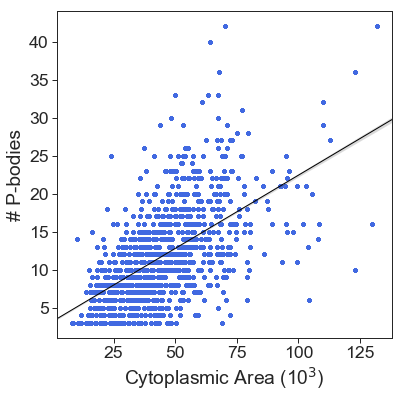

In [58]:
# Plot the number of P-bodies against area of the cytoplasm.
sns.set(context = "paper", font_scale = 2, rc = {'figure.figsize':(6, 6)})
sns.set_style("ticks")
ax = sns.regplot(x = results["Area_of_Cytoplasm"]/1000, y = results["Number_of_pbodies"],\
            scatter_kws={"color" : "royalblue","s": 10}, line_kws={'color': 'black', "lw" : 1})
ax.set_xlabel('Cytoplasmic Area (10$^3$)')
ax.set_ylabel('# P-bodies')
plt.show()

Text(0,0.5,'Density')

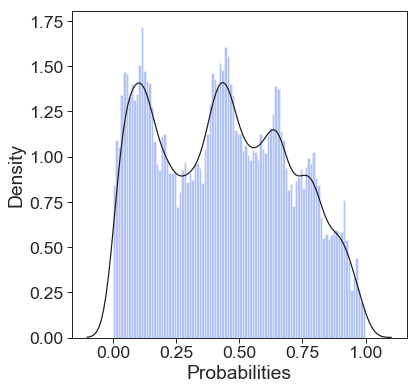

In [112]:
# Increase the number of bins on the p-value plots.
sns.set(context = "paper", font_scale = 2, rc = {'figure.figsize':(6, 6)})
sns.set_style("ticks")

ax = sns.distplot(results["p-value_measured_lower_1000_sim"], color = "royalblue", bins = 100, kde_kws={"color": "k"})
ax.set_xlabel('Probabilities')
ax.set_ylabel('Density')

In [70]:
# Importing intensity results.
# Analysing the results from area sampling.
base_path = '../results/run4_protein_measurements/Protein_intensities_'

# Load in all csv result files & combine them to one pandas table
wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',
         'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16',
         'E04', 'E05', 'E06', 'E07', 'E08', 'F04', 'F05', 'F06', 'F07', 'F08']

intensities = pd.DataFrame()

for well in wells:
    curr_well = pd.read_csv(base_path + well + '.csv')
    intensities = pd.concat([intensities, curr_well])

print(intensities.head())

   Area_of_Cytoplasm  Label  Mean_protein_intensity_around_pbodies  \
0            52160.0     27                              58.514882   
1            55056.0     28                              51.013752   
2            94739.0     14                              54.185152   
3            79842.0     35                              47.182697   
4            51296.0      9                              48.567493   

   Mean_protein_intensity_around_simulated_pbodies  \
0                                        53.602633   
1                                        58.378648   
2                                        50.498907   
3                                        54.466504   
4                                        52.927436   

   Mean_protein_intensity_cytoplasm  Number_of_pbodies  SiteX  SiteY Well  
0                         46.716104               17.0    0.0    0.0  C03  
1                         51.539469               14.0    0.0    0.0  C03  
2                         

(-20, 30)

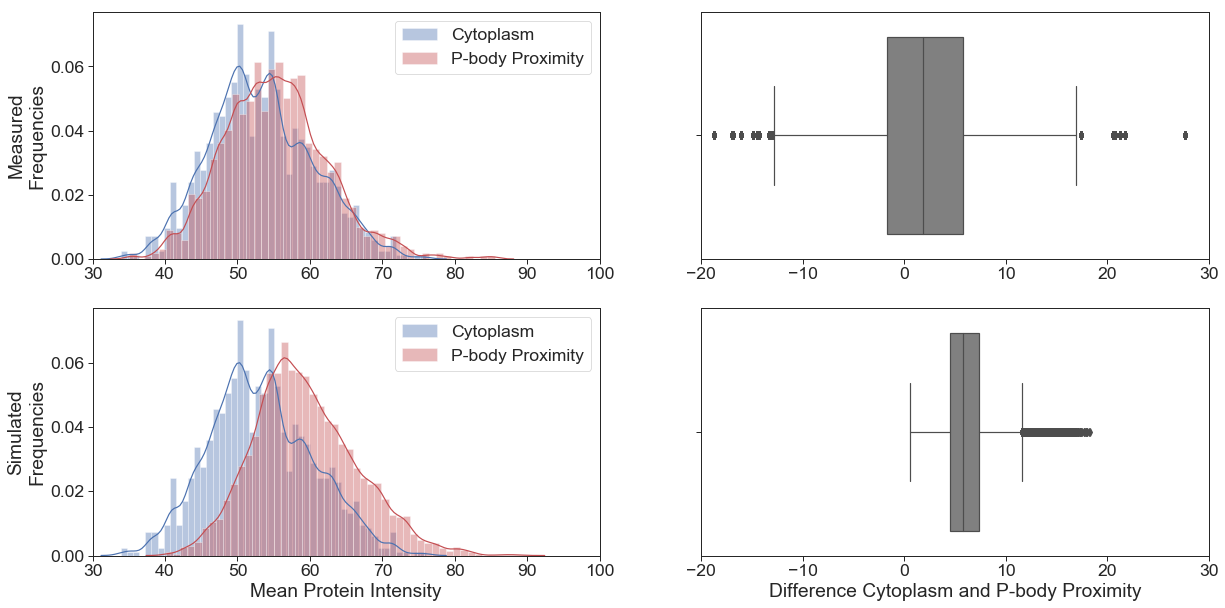

In [135]:
###### Calculating the differences (simulated and real) to average intensity in the cytoplasm.
intensityDiff = intensities["Mean_protein_intensity_around_pbodies"].values - intensities["Mean_protein_intensity_cytoplasm"].values
simIntensityDiff = intensities["Mean_protein_intensity_around_simulated_pbodies"].values - intensities["Mean_protein_intensity_cytoplasm"].values

# Plotting the distribution of the mean instensites in the cytoplasms and in the p-bodies.
sns.set(context = "paper", font_scale = 2)
sns.set_style("ticks")
figs, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10), gridspec_kw = {'width_ratios':[2, 2]})

cytoplasm1 = sns.distplot(a = intensities["Mean_protein_intensity_cytoplasm"], ax = axes[0, 0], label = "Cytoplasm")
p1 = sns.distplot(a = intensities["Mean_protein_intensity_around_pbodies"], color = 'r', ax = axes[0, 0], label = "P-body Proximity")
p1.set_xlabel(" ")
p1.set_xlim((30,100))
p1.set_ylabel("Measured\nFrequencies")
p1.legend()
p2 = sns.boxplot(intensityDiff, ax = axes[0, 1], color = 'grey')
p2.set_xlim((-20,30))

cytoplasm2 = sns.distplot(a = intensities["Mean_protein_intensity_cytoplasm"], ax = axes[1, 0], label = "Cytoplasm")
p3 = sns.distplot(a = intensities["Mean_protein_intensity_around_simulated_pbodies"], color = 'r', ax = axes[1, 0], label = "P-body Proximity")
p3.set_xlabel(" ")
p3.set_xlim((30,100))
p3.set_xlabel("Mean Protein Intensity")
p3.set_ylabel("Simulated\nFrequencies")
p3.legend()
p4 = sns.boxplot(simIntensityDiff, ax = axes[1, 1], color = 'grey')
p4.set_xlabel('Difference Cytoplasm and P-body Proximity')
p4.set_xlim((-20,30))

#sns.distplot(a = intensities["Mean_protein_intensity_cytoplasm"], ax = axes[1, 0])
#sns.distplot(a = intensities["Mean_protein_intensity_around_simulated_pbodies"], color = 'g', ax = axes[1, 1])
#sns.distplot(a = intensities["Mean_protein_intensity_cytoplasm"], ax = axes[1, 2])
#sns.distplot(a = intensities["Mean_protein_intensity_around_simulated_pbodies"], color = 'g', ax = axes[1, 2])